In [24]:
# #
# """
# this script converts the outputs from process_cast.m in matlab format (.mat) to .nc files
# """
#
# import numpy as np
# import scipy.io as sio
# import xarray as xr
# import os
#
#
# # ---------------------------------------------------------
# # Helper: convert MATLAB structs recursively into dicts
# # ---------------------------------------------------------
# def matlab_struct_to_dict(matobj):
#     out = {}
#     for field in matobj._fieldnames:
#         val = getattr(matobj, field)
#
#         # Nested struct
#         if hasattr(val, "_fieldnames"):
#             out[field] = matlab_struct_to_dict(val)
#
#         # MATLAB cell arrays → Python lists
#         elif isinstance(val, np.ndarray) and val.dtype == object:
#             out[field] = [matlab_struct_to_dict(v) if hasattr(v, "_fieldnames") else v
#                           for v in val]
#
#         else:
#             out[field] = val
#
#     return out
#
#
# # ---------------------------------------------------------
# # Helper: flatten nested dicts into xarray-friendly form
# # ---------------------------------------------------------
# def flatten_dict(prefix, d, out):
#     for key, val in d.items():
#         name = f"{prefix}_{key}" if prefix else key
#
#         if isinstance(val, dict):
#             flatten_dict(name, val, out)
#
#         else:
#             out[name] = val
#
#     return out
#
#
# # ---------------------------------------------------------
# # User settings
# # ---------------------------------------------------------
# file_dir = "/Users/iw2g24/PycharmProjects/COOKIES/Data/ladcp_data/"
# out_dir  = "/Users/iw2g24/PycharmProjects/COOKIES/Data/ladcp_nc/"
# # stations = ["001", "002", "003", "004", "005"]
# stations = ['034']
#
# os.makedirs(out_dir, exist_ok=True)
#
#
# # ---------------------------------------------------------
# # Process each station
# # ---------------------------------------------------------
# for stn in stations:
#
#     mat_path = os.path.join(file_dir, f"{stn}.mat")
#     if not os.path.exists(mat_path):
#         print(f"Missing: {mat_path}")
#         continue
#
#     print(f"Processing {mat_path}")
#
#     # Load MAT file
#     mat = sio.loadmat(mat_path, squeeze_me=True, struct_as_record=False)
#
#     # Extract MATLAB structs
#     structs = {}
#     for key, val in mat.items():
#         if hasattr(val, "_fieldnames"):
#             structs[key] = matlab_struct_to_dict(val)
#
#     # Flatten all structs into a single dictionary
#     flat = {}
#     for name, struct in structs.items():
#         flat = flatten_dict(name, struct, flat)
#
#     # Build xarray Dataset
#     ds = xr.Dataset()
#
#     for key, val in flat.items():
#
#         # Scalars → attributes
#         if np.isscalar(val) or isinstance(val, (str, bytes)):
#             ds.attrs[key] = val
#
#         # 1D or 2D numeric arrays → variables
#         elif isinstance(val, np.ndarray) and np.issubdtype(val.dtype, np.number):
#             if val.ndim == 1:
#                 ds[key] = ("dim_" + key, val)
#             elif val.ndim == 2:
#                 ds[key] = (("dim0_" + key, "dim1_" + key), val)
#
#         # Everything else → store as string attribute
#         else:
#             ds.attrs[key] = str(val)
#
#     # Save NetCDF
#     out_path = os.path.join(out_dir, f"ladcp_{stn}.nc")
#     ds.to_netcdf(out_path)
#
#     print(f"Saved NetCDF → {out_path}")


In [25]:
from scipy.ndimage import gaussian_filter1d
import glob
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.colors as mcolors

In [26]:
# import xarray as xr
#
# # Open dataset
# station_33 = xr.open_dataset(
#     '/Users/iw2g24/PycharmProjects/COOKIES/Data/ladcp_nc/ladcp_033_old.nc'
# )
#
# # New values
# set_lon = 132.37
# set_lat = -64.67
#
# # Overwrite values
# station_33["dr_shiplon"] = set_lon
# station_33["dr_shiplat"] = set_lat
#
# # Save to new file (recommended — safer)
# station_33.to_netcdf(
#     '/Users/iw2g24/PycharmProjects/COOKIES/Data/ladcp_nc/ladcp_033.nc'
# )
#
# print("Updated and saved successfully.")
#


In [50]:
data_dir = '/Users/iw2g24/PycharmProjects/COOKIES/Data/ctd_data/'

# Find all NetCDF files
files = glob.glob(os.path.join(data_dir, 'in2026_v01_*', 'in2026_v01_*.nc'))

# Sort numerically by station number
files = sorted(files, key=lambda f: int(os.path.basename(f).split('_')[-1].split('.')[0]))

datasets = {}
stations_all = []

for file_name in files:
    stn = os.path.basename(file_name).split('_')[-1].split('.')[0]
    stations_all.append(stn)
    datasets[stn] = xr.open_dataset(file_name, decode_timedelta=False)
    print(f"Opened dataset for station {stn}")

for stn, ds in datasets.items():
    print(stn)


Opened dataset for station 001
Opened dataset for station 002
Opened dataset for station 003
Opened dataset for station 004
Opened dataset for station 005
Opened dataset for station 006
Opened dataset for station 007
Opened dataset for station 008
Opened dataset for station 009
Opened dataset for station 010
Opened dataset for station 011
Opened dataset for station 012
Opened dataset for station 013
Opened dataset for station 014
Opened dataset for station 015
Opened dataset for station 016
Opened dataset for station 017
Opened dataset for station 018
Opened dataset for station 019
Opened dataset for station 020
Opened dataset for station 021
Opened dataset for station 022
Opened dataset for station 023
Opened dataset for station 024
Opened dataset for station 025
Opened dataset for station 026
Opened dataset for station 027
Opened dataset for station 028
Opened dataset for station 029
Opened dataset for station 030
Opened dataset for station 031
Opened dataset for station 032
Opened d

<xarray.DataArray 'dim_dr_u' (dim_dr_u: 101)> Size: 808B
[101 values with dtype=int64]
Dimensions without coordinates: dim_dr_u


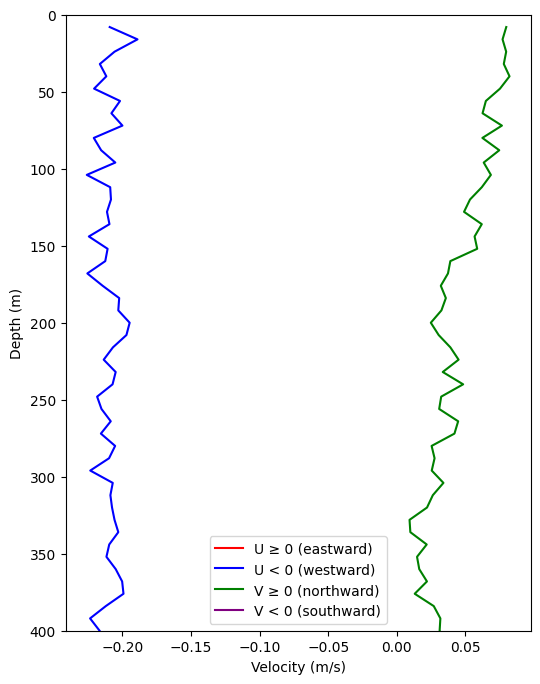

['dr_date', 'dr_zbot', 'dr_ubot', 'dr_vbot', 'dr_uerrbot', 'dr_z', 'dr_u', 'dr_v', 'dr_nvel', 'dr_tim', 'dr_tim_hour', 'dr_zctd', 'dr_wctd', 'dr_uctd', 'dr_vctd', 'dr_xctd', 'dr_yctd', 'dr_uerr', 'dr_range', 'dr_range_do', 'dr_range_up', 'dr_ts', 'dr_ts_out', 'dr_p', 'dr_uctderr', 'dr_u_do', 'dr_v_do', 'dr_u_up', 'dr_v_up', 'dr_ensemble_vel_err', 'dr_u_shear_method', 'dr_v_shear_method', 'dr_w_shear_method', 'p_zpar', 'p_saveplot', 'p_saveplot_png', 'p_saveplot_pdf', 'p_checkpoints', 'p_ignore_beam', 'p_tiltmax', 'p_serial_cpu_d', 'p_nping_total', 'p_instid', 'p_serial_cpu_u', 'p_wizr', 'p_time_start', 'p_time_end', 'p_xmc', 'p_xmv', 'p_tint', 'p_outlier', 'p_btrk_range', 'p_dzbelow', 'p_up_range', 'p_dn_range', 'p_poss', 'p_pose', 'p_wbslope', 'ps_smallfac', 'ps_btrk_weight_nblen', 'f_ctd', 'f_nav', 'da_LADCP_dn_beam_range', 'da_LADCP_up_beam_range', 'da_GEN_Editing_parm_descr', 'dr_lon', 'dr_lat', 'dr_shiplon', 'dr_shiplat']
<xarray.Dataset> Size: 25kB
Dimensions:                    

In [36]:
ladcp_data = xr.open_dataset('/Users/iw2g24/PycharmProjects/COOKIES/Data/ladcp_nc/ladcp_033.nc')
print(ladcp_data.dim_dr_u)

u = ladcp_data["dr_u"].values
v = ladcp_data["dr_v"].values
z = ladcp_data["dr_z"].values
p = ladcp_data["dr_p"].values

plt.figure(figsize=(6,8))

# --- U component ---
plt.plot(np.where(u >= 0, u, np.nan), z, color="red", label="U ≥ 0 (eastward)")
plt.plot(np.where(u < 0,  u, np.nan), z, color="blue", label="U < 0 (westward)")

# --- V component ---
plt.plot(np.where(v >= 0, v, np.nan), z, color="green", label="V ≥ 0 (northward)")
plt.plot(np.where(v < 0,  v, np.nan), z, color="purple", label="V < 0 (southward)")

plt.gca().invert_yaxis()
plt.xlabel("Velocity (m/s)")
plt.ylabel("Depth (m)")
plt.ylim(400,0)
plt.legend()
plt.show()

print(list(ladcp_data.keys()))
print(ladcp_data)
print(list(ladcp_data.variables))


print('ship lon:', ladcp_data["dr_shiplon"].values)
print('ship lat:', ladcp_data["dr_shiplat"].values)

# print(ladcp_data["dr_lon"].values)

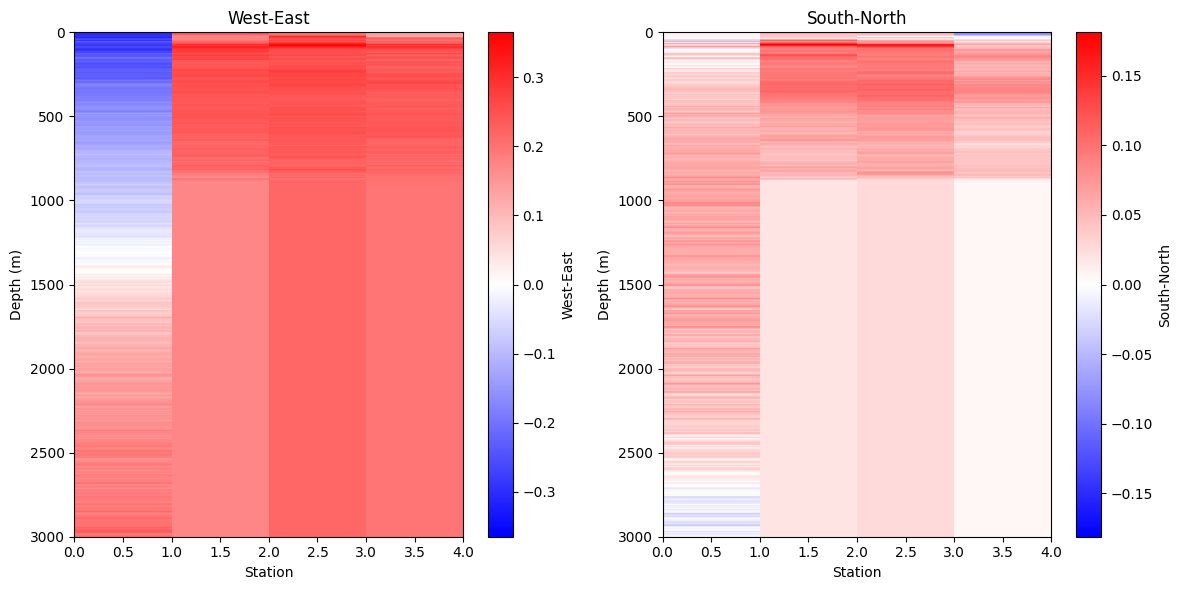

In [37]:
us = []
vs = []
depths = []

# stations = ['002','003', '004', '005', '006']
# stations = ['017']
stations = ['020', '021', '022', '023'] #full cast, then 3 yoyo CTDs at C28 (above sediment waves)

for stn in stations:
    ds = xr.open_dataset(f'/Users/iw2g24/PycharmProjects/COOKIES/Data/ladcp_nc/ladcp_{stn}.nc')
    u = ds.dr_u.values
    v = ds.dr_v.values
    z = ds.dr_z.values

    us.append(u)
    vs.append(v)
    depths.append(z)

z_min = min(z.min() for z in depths)   # shallowest common depth
z_max = max(z.max() for z in depths)   # deepest common depth

# Ensure increasing depth
if z_min > z_max:
    z_min, z_max = z_max, z_min

z_grid = np.linspace(z_min, z_max, 1200)

u_grid = np.vstack([np.interp(z_grid, depths[i], us[i]) for i in range(len(stations))])
v_grid = np.vstack([np.interp(z_grid, depths[i], vs[i]) for i in range(len(stations))])

# x: station index
x = np.arange(len(stations))
x_edges = np.arange(len(stations) + 1)

# y: depth edges
z_edges = np.zeros(len(z_grid) + 1)
z_edges[1:-1] = (z_grid[:-1] + z_grid[1:]) / 2
z_edges[0] = z_grid[0] - (z_grid[1] - z_grid[0]) / 2
z_edges[-1] = z_grid[-1] + (z_grid[-1] - z_grid[-2]) / 2

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

variables = [
    (u_grid, "West-East", "bwr"),
    (v_grid, "South-North", "bwr"),
]

for ax, (var2d, title, cmap) in zip(axs, variables):
    # Make symmetric color limits around 0
    abs_max = np.max(np.abs(var2d))
    vmin, vmax = -abs_max, abs_max

    pcm = ax.pcolormesh(
        x_edges,
        z_edges,
        var2d.T,
        shading='auto',
        cmap=cmap,
        vmin=vmin,
        vmax=vmax
    )

    ax.invert_yaxis()
    ax.set_title(title)
    ax.set_xlabel("Station")
    ax.set_ylabel("Depth (m)")
    ax.set_ylim(3000, 0)

    cbar = plt.colorbar(pcm, ax=ax)
    cbar.set_label(title)

plt.tight_layout()
plt.show()


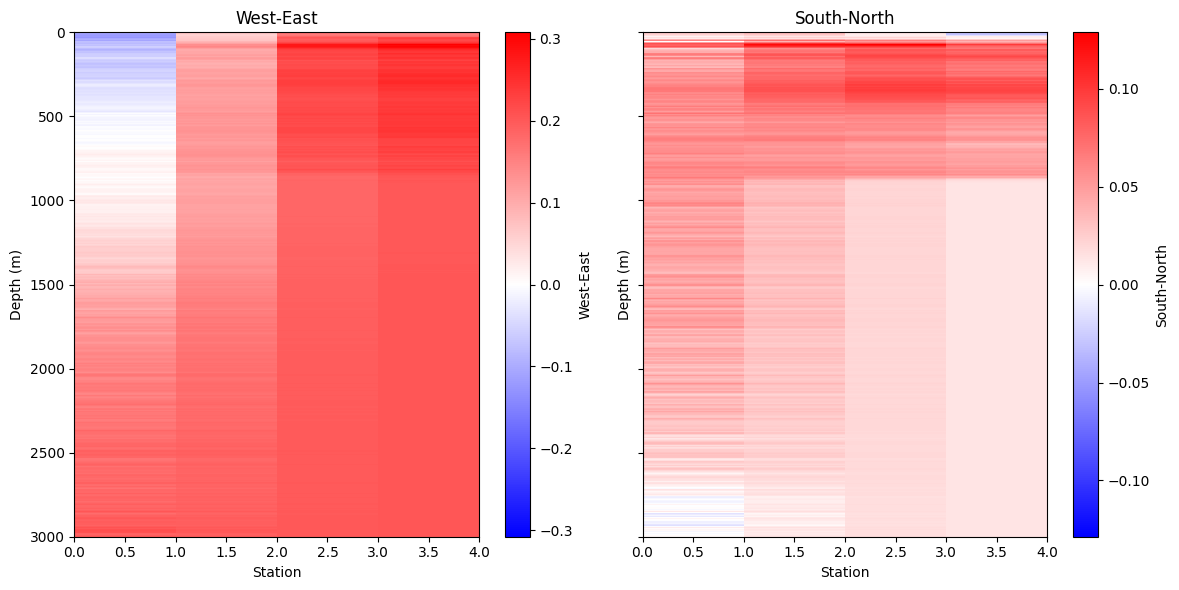

In [38]:
# -----------------------------
# 1. Build smoothed transect grids
# -----------------------------

sigma = 1.0

u_grid_smooth  = gaussian_filter1d(u_grid,  sigma=sigma, axis=0)
v_grid_smooth = gaussian_filter1d(v_grid, sigma=sigma, axis=0)


# -----------------------------
# 2. Plot smoothed transects with zero-centered colorbars
# -----------------------------

fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

variables = [
    (u_grid_smooth,  "West-East", "bwr"),  # use diverging colormap
    (v_grid_smooth, "South-North", "bwr")
]

for ax, (var2d, title, cmap) in zip(axs, variables):
    # make color limits symmetric around zero
    abs_max = np.max(np.abs(var2d))
    vmin, vmax = -abs_max, abs_max

    pcm = ax.pcolormesh(
        x_edges,
        z_edges,
        var2d.T,
        shading='auto',
        cmap=cmap,
        vmin=vmin,
        vmax=vmax
    )


    ax.invert_yaxis()
    ax.set_title(title)
    ax.set_xlabel("Station")
    ax.set_ylabel("Depth (m)")
    ax.set_ylim(3000, 0)

    cbar = plt.colorbar(pcm, ax=ax)
    cbar.set_label(title)

plt.tight_layout()
plt.show()


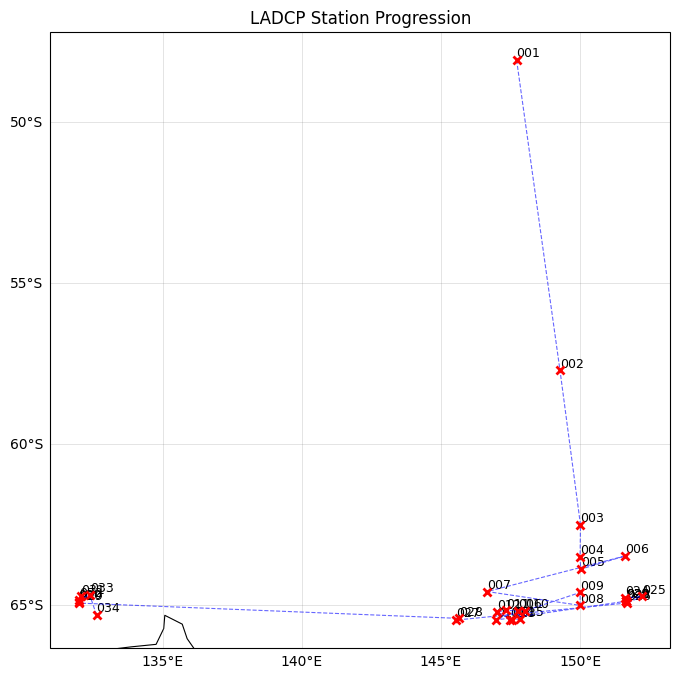

In [39]:
stations = []
mean_lon = []
mean_lat = []

ladcp_dir = '/Users/iw2g24/PycharmProjects/COOKIES/Data/ladcp_nc/'
ladcp_files = glob.glob(os.path.join(ladcp_dir, '*.nc'))
ladcp_files = sorted(
    ladcp_files,
    key=lambda f: int(os.path.splitext(os.path.basename(f))[0].split('_')[-1])
)

for f in ladcp_files:
    ds = xr.open_dataset(f)

    # Extract station number from filename
    stn = os.path.basename(f).split("_")[1].split(".")[0]
    stations.append(stn)

    # Mean position (handles scalar or array)
    mean_lon.append(float(ds.dr_lon.mean()))
    mean_lat.append(float(ds.dr_lat.mean()))

    # mean_lon.append(float(ds.dr_shiplon.mean()))
    # mean_lat.append(float(ds.dr_shiplat.mean()))

mean_lon = np.array(mean_lon)
mean_lat = np.array(mean_lat)

# ----------------------------------
# Plot
# ----------------------------------
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=proj)

# Coastlines
ax.coastlines(resolution="110m", linewidth=0.8)
ax.set_aspect('auto') #just added this now
# Track line
ax.plot(
    mean_lon,
    mean_lat,
    linestyle="--",
    color="blue",
    linewidth=0.8,
    alpha=0.6,
    transform=ccrs.PlateCarree(),
    zorder=4,
)

# Station markers
ax.plot(
    mean_lon,
    mean_lat,
    linestyle="None",
    marker="x",
    color="red",
    markersize=6,
    markeredgewidth=2,
    transform=ccrs.PlateCarree(),
    zorder=5,
)

# Station labels
for stn, lon, lat in zip(stations, mean_lon, mean_lat):
    ax.text(
        lon,
        lat,
        stn,
        transform=ccrs.PlateCarree(),
        fontsize=9,
        ha="left",
        va="bottom",
    )

# ----------------------------------
# Gridlines
# ----------------------------------
lon_ticks = np.arange(-180, 181, 5)
lat_ticks = np.arange(-90, 91, 5)

gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=0.5,
    color="gray",
    alpha=0.3,
    linestyle="-",
    xlocs=lon_ticks,
    ylocs=lat_ticks,
)

gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {"size": 10}
gl.ylabel_style = {"size": 10}

ax.set_title("LADCP Station Progression")

plt.show()


In [40]:
print(stations)

['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034']


In [41]:
print(ds.variables)

Frozen({'dr_date': <xarray.Variable (dim_dr_date: 6)> Size: 12B
[6 values with dtype=uint16], 'dr_zbot': <xarray.Variable (dim_dr_zbot: 23)> Size: 46B
[23 values with dtype=uint16], 'dr_ubot': <xarray.Variable (dim_dr_ubot: 23)> Size: 184B
[23 values with dtype=float64], 'dr_vbot': <xarray.Variable (dim_dr_vbot: 23)> Size: 184B
[23 values with dtype=float64], 'dr_uerrbot': <xarray.Variable (dim_dr_uerrbot: 23)> Size: 184B
[23 values with dtype=float64], 'dr_z': <xarray.Variable (dim_dr_z: 107)> Size: 214B
[107 values with dtype=uint16], 'dr_u': <xarray.Variable (dim_dr_u: 107)> Size: 856B
[107 values with dtype=float64], 'dr_v': <xarray.Variable (dim_dr_v: 107)> Size: 856B
[107 values with dtype=float64], 'dr_nvel': <xarray.Variable (dim_dr_nvel: 107)> Size: 107B
[107 values with dtype=uint8], 'dr_tim': <xarray.Variable (dim_dr_tim: 175)> Size: 1kB
[175 values with dtype=float64], 'dr_tim_hour': <xarray.Variable (dim_dr_tim_hour: 175)> Size: 1kB
[175 values with dtype=float64], 'dr_shi

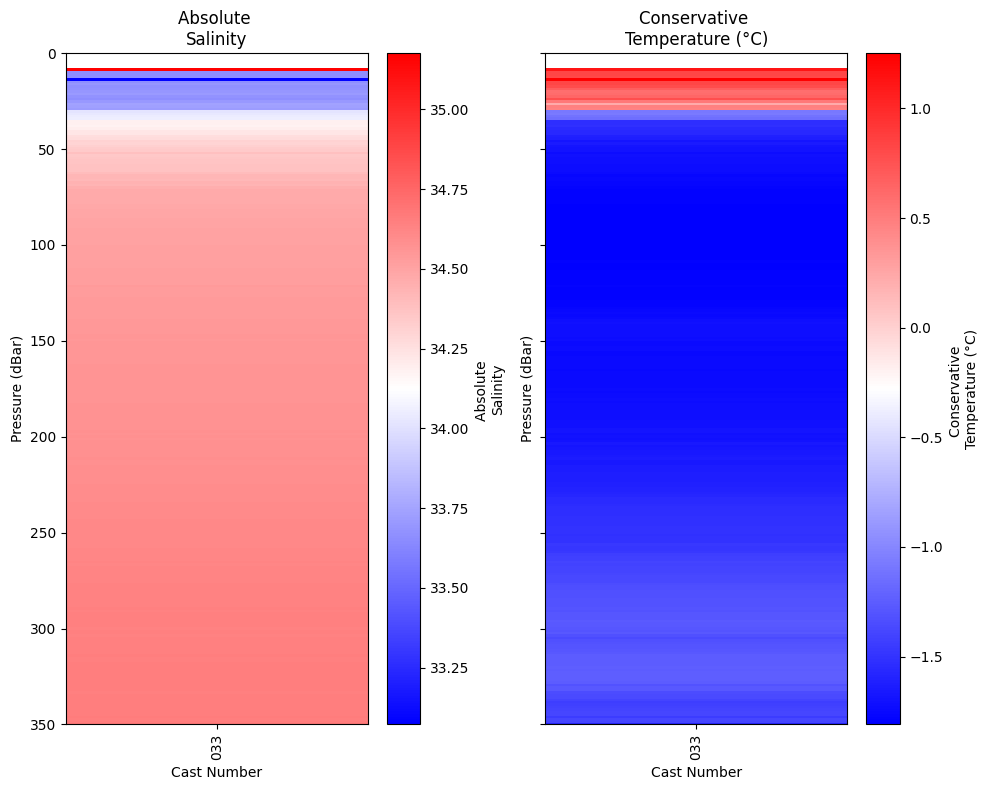

In [34]:
pressures = []
temps = []
sals = []
conds = []
fluro = []
rho0 = []

# stations = ['002', '003', '004', '005', '006', '007', '008', '009']
# stations = ['010', '016', '011','012']  #station list for northern canyon transect
# stations = [ '015', '013', '014', '017']
# stations = ['031', '032', '030', '029']
# stations = ['029', '030', '032', '031', '032', '033', '034'] #dibble stations
# stations = ['020', '021', '022', '023'] #full cast, then 3 yoyo CTDs at C28 (above sediment waves)

stations = ['033']

y_min = 0
y_max = 350

for stn in stations:
    ds = datasets[stn]

    # --- Extract variables ---
    p = ds.prDM.values
    # t = ds.t090C.values
    # s = ds.sal00.values
    t = ds.CT.values
    s = ds.SA.values
    c = ds.c0Sperm.values
    f = ds.flECO_AFL.values
    rho_anom = ds.sigma0.values

    # --- Mask to in-water (pressure > 8.5 dbar) ---
    mask = p > 8.5
    p = p[mask]
    t = t[mask]
    s = s[mask]
    c = c[mask]
    f = f[mask]
    rho_anom = rho_anom[mask]

    # --- Sort by pressure (increasing) ---
    order = np.argsort(p)
    p = p[order]
    t = t[order]
    s = s[order]
    c = c[order]
    f = f[order]
    rho_anom = rho_anom[order]

    # --- Append to lists ---
    pressures.append(p)
    temps.append(t)
    sals.append(s)
    conds.append(c)
    fluro.append(f)
    rho0.append(rho_anom)

p_min = min(p[0] for p in pressures)
p_max = max(p[-1] for p in pressures)
p_grid = np.linspace(p_min, p_max, 600)

temp_grid = np.vstack([
    np.interp(p_grid, pressures[i], temps[i], left=np.nan, right=np.nan)
    for i in range(len(stations))
])

sal_grid = np.vstack([
    np.interp(p_grid, pressures[i], sals[i], left=np.nan, right=np.nan)
    for i in range(len(stations))
])

cond_grid = np.vstack([
    np.interp(p_grid, pressures[i], conds[i], left=np.nan, right=np.nan)
    for i in range(len(stations))
])

fluro_grid = np.vstack([
    np.interp(p_grid, pressures[i], fluro[i], left=np.nan, right=np.nan)
    for i in range(len(stations))
])

rho0_grid = np.vstack([
    np.interp(p_grid, pressures[i], rho0[i], left=np.nan, right=np.nan)
    for i in range(len(stations))
])

# # x: station index
x = np.arange(len(stations))
x_edges = np.arange(len(stations) + 1)

# y: pressure edges
p_edges = np.zeros(len(p_grid) + 1)
p_edges[1:-1] = (p_grid[:-1] + p_grid[1:]) / 2
p_edges[0] = p_grid[0] - (p_grid[1] - p_grid[0]) / 2
p_edges[-1] = p_grid[-1] + (p_grid[-1] - p_grid[-2]) / 2

fig, axs = plt.subplots(1, 2, figsize=(10,8), sharey=True)

variables = [
    (sal_grid,  "Absolute \nSalinity",        "bwr", np.nanmin(sal_grid), np.nanmax(sal_grid)),

    (temp_grid, "Conservative \nTemperature (°C)", "bwr", np.nanmin(temp_grid), np.nanmax(temp_grid)),

]


for ax, (var2d, title, cmap, vmin, vmax) in zip(axs, variables):

    pcm = ax.pcolormesh(
        x_edges,
        p_edges,
        var2d.T,        # shape must be (pressure, station)
        shading='auto',
        cmap=cmap,
        vmin=vmin,
        vmax=vmax
    )

    # Set station numbers as x-ticks
    ax.set_xticks(x+0.5)
    ax.set_xticklabels(stations)
    ax.tick_params(axis='x', labelrotation=90)

    # ax.invert_yaxis()
    ax.set_title(title)
    ax.set_xlabel("Cast Number")
    ax.set_ylabel("Pressure (dBar)")


    cbar = plt.colorbar(pcm, ax=ax)
    cbar.set_label(title)


axs[0].set_ylim(y_min, y_max)
axs[0].invert_yaxis()
plt.tight_layout()
plt.show()


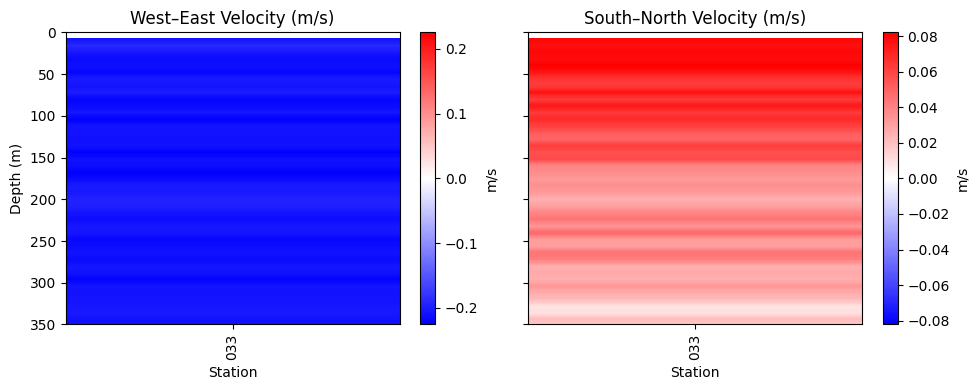

In [20]:
# stations = ['010', '011', '012']
# stations = [ '012', '013']
file_dir = "/Users/iw2g24/PycharmProjects/COOKIES/Data/ladcp_nc"
files = [
    os.path.join(file_dir, f"ladcp_{stn}.nc")
    for stn in stations
]

y_min = 0
y_max = 350

us, vs, depths = [], [], []


for f in files:
    ds = xr.open_dataset(f)

    us.append(ds.dr_u.values)
    vs.append(ds.dr_v.values)
    depths.append(ds.dr_z.values)

z_min = min(z.min() for z in depths)
z_max = max(z.max() for z in depths)


z_grid = np.linspace(z_min, z_max, 600)

u_grid = np.vstack([
    np.interp(z_grid, depths[i], us[i], left=np.nan, right=np.nan)
    for i in range(len(files))
])
v_grid = np.vstack([
    np.interp(z_grid, depths[i], vs[i], left=np.nan, right=np.nan)
    for i in range(len(files))
])


x = np.arange(len(files))
x_edges = np.arange(len(files) + 1)

z_edges = np.zeros(len(z_grid) + 1)
z_edges[1:-1] = (z_grid[:-1] + z_grid[1:]) / 2
z_edges[0] = z_grid[0] - (z_grid[1] - z_grid[0]) / 2
z_edges[-1] = z_grid[-1] + (z_grid[-1] - z_grid[-2]) / 2

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

variables = [
    (u_grid, "West–East Velocity (m/s)", "bwr"),
    (v_grid, "South–North Velocity (m/s)", "bwr"),
]

for ax, (var2d, title, cmap) in zip(axs, variables):
    abs_max = np.nanmax(np.abs(var2d))

    pcm = ax.pcolormesh(
        x_edges,
        z_edges,
        var2d.T,
        cmap=cmap,
        shading="auto",
        vmin=-abs_max,
        vmax=abs_max,
    )

    # ax.invert_yaxis()
    ax.set_title(title)
    ax.set_xlabel("Station")
    ax.set_xticks(x + 0.5)
    ax.set_xticklabels(stations)
    ax.tick_params(axis='x', labelrotation=90)

    cbar = plt.colorbar(pcm, ax=ax)
    cbar.set_label("m/s")

axs[0].set_ylabel("Depth (m)")
axs[0].set_ylim(y_min, y_max)
ax.invert_yaxis()
plt.tight_layout()
plt.show()




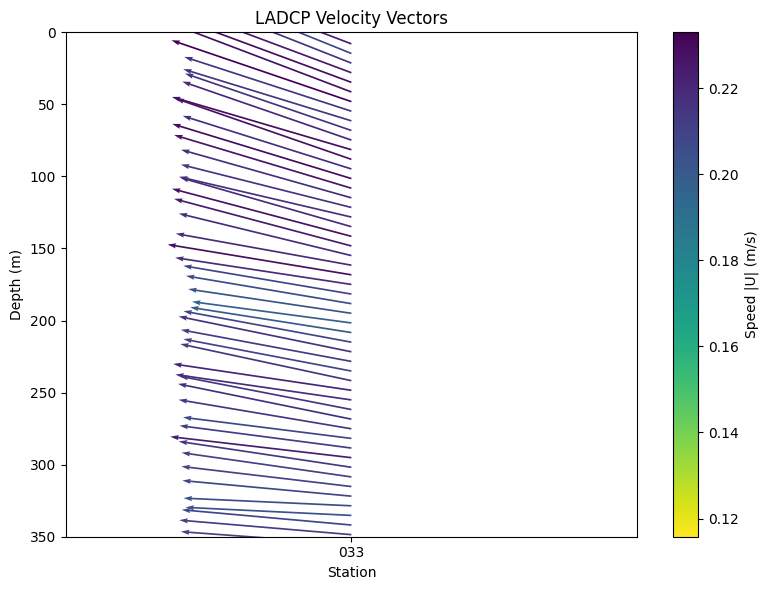

In [21]:
ymin = 0
ymax = 350

# --- Prepare coordinates ---
x = np.arange(len(stations)) + 0.5   # center of each station column
X, Z = np.meshgrid(x, z_grid)

# --- Speed for optional coloring ---
U = np.sqrt(u_grid**2 + v_grid**2)

# --- Subsample in depth to reduce clutter ---
step = 5   # increase if too crowded
Xq = X[::step, :]
Zq = Z[::step, :]
Uq = u_grid[:, ::step].T
Vq = v_grid[:, ::step].T
Cq = U[:, ::step].T

# --- Plot ---
plt.figure(figsize=(8, 6))

q = plt.quiver(
    Xq, Zq,
    Uq, Vq,
    Cq,
    cmap="viridis_r",
    scale=0.7,
    width=0.003,

)


plt.ylim(ymax, ymin)
plt.ylabel("Depth (m)")
plt.xlabel("Station")
plt.xticks(x, stations)
plt.xlim(0, len(stations))
plt.title("LADCP Velocity Vectors")

cbar = plt.colorbar(q)
cbar.set_label("Speed |U| (m/s)")

plt.tight_layout()
plt.show()



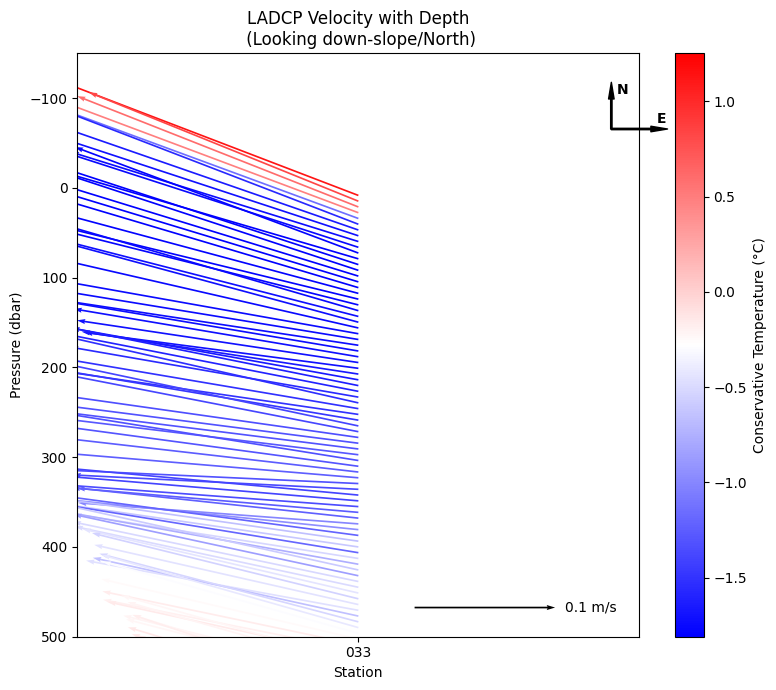

In [22]:
"""
quiver plot with temp as colour for Canyon stations
"""
ymin = 0
ymax = 350

u_on_p = np.vstack([
    np.interp(p_grid, z_grid, u_grid[i], left=np.nan, right=np.nan)
    for i in range(len(stations))
])

v_on_p = np.vstack([
    np.interp(p_grid, z_grid, v_grid[i], left=np.nan, right=np.nan)
    for i in range(len(stations))
])

assert u_on_p.shape == (len(stations), len(p_grid))
assert v_on_p.shape == (len(stations), len(p_grid))

# --- Prepare coordinates ---
x = np.arange(len(stations)) + 0.5   # center of each station column
X, P = np.meshgrid(x, p_grid)

U = u_on_p.T
V = v_on_p.T
T = temp_grid.T   # CTD temperature for color


step = 5
Xq = X[::step, :]
Pq = P[::step, :]
Uq = U[::step, :]
Vq = V[::step, :]
Tq = T[::step, :]

assert Uq.shape == Vq.shape == Tq.shape, "Shapes of U, V, and T do not match!"

# --- define min/max for color ---
t_min = np.nanmin(temp_grid)
t_max = np.nanmax(temp_grid)

norm = mcolors.Normalize(vmin=t_min, vmax=t_max)

plt.figure(figsize=(8, 7))

q = plt.quiver(
    Xq, Pq,
    Uq, Vq,
    Tq,               # color values
    cmap="bwr",
    norm=norm,        # ← apply normalization here
    scale=0.4,
    width=0.003
)


plt.xticks(x, stations)
# plt.xlim(0, len(stations))
# plt.ylim(y_max, y_min)

# x-axis (stations)
plt.xlim(-0.2, len(stations) - 1 + 1.2)  # add 0.2–1 unit padding
# y-axis (pressure)
plt.ylim(y_max + 150, y_min - 150)  # add 150 dbar padding top and bottom

plt.xlabel("Station")
plt.ylabel("Pressure (dbar)")
# plt.title("LADCP Velocity Vectors Colored by CTD Temperature\n view is Southward:\n Left = Ross Sea,  Right = Totten")
plt.title("LADCP Velocity with Depth\n (Looking down-slope/North)")
cbar = plt.colorbar(q)
cbar.set_label("Conservative Temperature (°C)")

plt.quiverkey(q, X=0.85, Y=0.05, U=0.1, label='0.1 m/s', labelpos='E')

# North Arrow
plt.annotate(
    '',                   # no text
    xy=(0.95, 0.95),      # arrow tip in axes fraction (right top)
    xytext=(0.95, 0.87),  # arrow tail
    xycoords='axes fraction',
    textcoords='axes fraction',
    arrowprops=dict(facecolor='k', width=1, headwidth=4)
)
plt.text(0.96, 0.93, 'N', transform=plt.gca().transAxes, fontsize=10, fontweight='bold')

#East arrow
plt.annotate(
    '', xy=(1.05, 0.87), xytext=(0.95, 0.87),  # same y-coordinate
    xycoords='axes fraction', textcoords='axes fraction',
    arrowprops=dict(facecolor='k', width=1, headwidth=4)
)
plt.text(1.03, 0.88, 'E', transform=plt.gca().transAxes, fontsize=10, fontweight='bold')


plt.tight_layout()
plt.show()



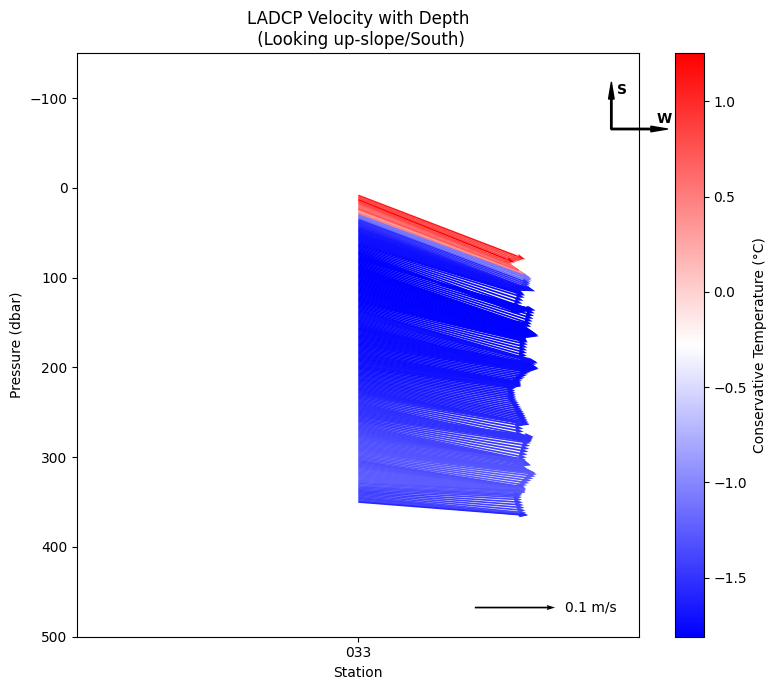

In [23]:
"""
quiver plot with temp as colour for Canyon stations
"""
ymin = 0
ymax = 350



u_on_p = np.vstack([
    np.interp(p_grid, z_grid, u_grid[i], left=np.nan, right=np.nan)
    for i in range(len(stations))
])

v_on_p = np.vstack([
    np.interp(p_grid, z_grid, v_grid[i], left=np.nan, right=np.nan)
    for i in range(len(stations))
])

assert u_on_p.shape == (len(stations), len(p_grid))
assert v_on_p.shape == (len(stations), len(p_grid))

# --- Prepare coordinates ---
x = np.arange(len(stations)) + 0.5   # center of each station column
X, P = np.meshgrid(x, p_grid)

U = -(u_on_p.T)
V =-(v_on_p.T)
T = temp_grid.T   # CTD temperature for color


step = 1
Xq = X[::step, :]
Pq = P[::step, :]
Uq = U[::step, :]
Vq = V[::step, :]
Tq = T[::step, :]

mask = (p_grid >= ymin) & (p_grid <= ymax)
Xq = X[mask, :]
Pq = P[mask, :]
Uq = U[mask, :]
Vq = V[mask, :]
Tq = T[mask, :]


# --- define min/max for color ---
t_min = np.nanmin(temp_grid)
t_max = np.nanmax(temp_grid)

norm = mcolors.Normalize(vmin=t_min, vmax=t_max)

plt.figure(figsize=(8, 7))

q = plt.quiver(
    Xq, Pq,
    Uq, Vq,
    Tq,               # color values
    cmap="bwr",
    norm=norm,        # ← apply normalization here
    scale=0.7,
    width=0.003
)


plt.xticks(x, stations)
# plt.xlim(0, len(stations))
# plt.ylim(y_max, y_min)

# x-axis (stations)
plt.xlim(-0.2, len(stations) - 1 + 1.2)  # add 0.2–1 unit padding
# y-axis (pressure)
plt.ylim(y_max + 150, y_min - 150)  # add 150 dbar padding top and bottom


plt.xlabel("Station")
plt.ylabel("Pressure (dbar)")
# plt.title("LADCP Velocity Vectors Colored by CTD Temperature\n view is Southward:\n Left = Ross Sea,  Right = Totten")
plt.title("LADCP Velocity with Depth\n (Looking up-slope/South)")
cbar = plt.colorbar(q)
cbar.set_label("Conservative Temperature (°C)")

plt.quiverkey(q, X=0.85, Y=0.05, U=0.1, label='0.1 m/s', labelpos='E')

# North Arrow
plt.annotate(
    '',                   # no text
    xy=(0.95, 0.95),      # arrow tip in axes fraction (right top)
    xytext=(0.95, 0.87),  # arrow tail
    xycoords='axes fraction',
    textcoords='axes fraction',
    arrowprops=dict(facecolor='k', width=1, headwidth=4)
)
plt.text(0.96, 0.93, 'S', transform=plt.gca().transAxes, fontsize=10, fontweight='bold')

#East arrow
plt.annotate(
    '', xy=(1.05, 0.87), xytext=(0.95, 0.87),  # same y-coordinate
    xycoords='axes fraction', textcoords='axes fraction',
    arrowprops=dict(facecolor='k', width=1, headwidth=4)
)
plt.text(1.03, 0.88, 'W', transform=plt.gca().transAxes, fontsize=10, fontweight='bold')


plt.tight_layout()
plt.show()


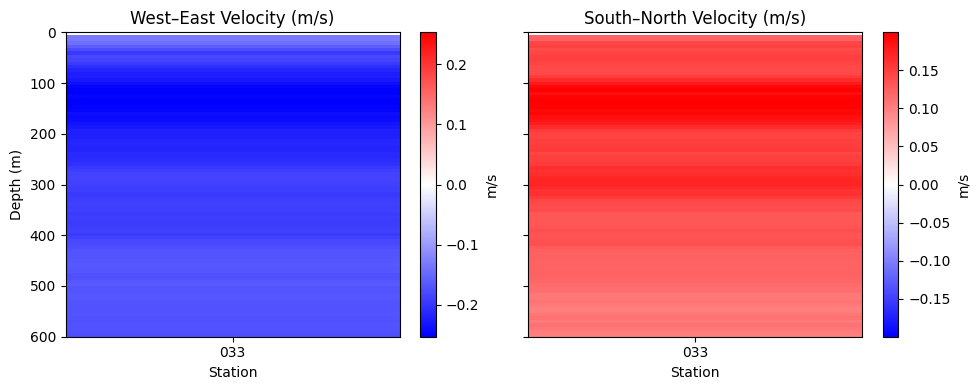

In [24]:
# stations = ['002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013']
#
# file_dir = "/Users/iw2g24/PycharmProjects/COOKIES/ladcp_nc"
# files = [
#     os.path.join(file_dir, f"ladcp_{stn}.nc")
#     for stn in stations
# ]

y_min = 0
y_max = 600

us, vs, depths = [], [], []


for f in ladcp_files:
    ds = xr.open_dataset(f)

    us.append(ds.dr_u.values)
    vs.append(ds.dr_v.values)
    depths.append(ds.dr_z.values)

z_min = min(z.min() for z in depths)
z_max = max(z.max() for z in depths)


z_grid = np.linspace(z_min, z_max, 600)

u_grid = np.vstack([
    np.interp(z_grid, depths[i], us[i], left=np.nan, right=np.nan)
    for i in range(len(files))
])
v_grid = np.vstack([
    np.interp(z_grid, depths[i], vs[i], left=np.nan, right=np.nan)
    for i in range(len(files))
])


x = np.arange(len(files))
x_edges = np.arange(len(files) + 1)

z_edges = np.zeros(len(z_grid) + 1)
z_edges[1:-1] = (z_grid[:-1] + z_grid[1:]) / 2
z_edges[0] = z_grid[0] - (z_grid[1] - z_grid[0]) / 2
z_edges[-1] = z_grid[-1] + (z_grid[-1] - z_grid[-2]) / 2

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

variables = [
    (u_grid, "West–East Velocity (m/s)", "bwr"),
    (v_grid, "South–North Velocity (m/s)", "bwr"),
]

for ax, (var2d, title, cmap) in zip(axs, variables):
    abs_max = np.nanmax(np.abs(var2d))

    pcm = ax.pcolormesh(
        x_edges,
        z_edges,
        var2d.T,
        cmap=cmap,
        shading="auto",
        vmin=-abs_max,
        vmax=abs_max,
    )

    # ax.invert_yaxis()
    ax.set_title(title)
    ax.set_xlabel("Station")
    ax.set_xticks(x + 0.5)
    ax.set_xticklabels(stations)

    cbar = plt.colorbar(pcm, ax=ax)
    cbar.set_label("m/s")

axs[0].set_ylabel("Depth (m)")
axs[0].set_ylim(y_min, y_max)
ax.invert_yaxis()
plt.tight_layout()
plt.show()




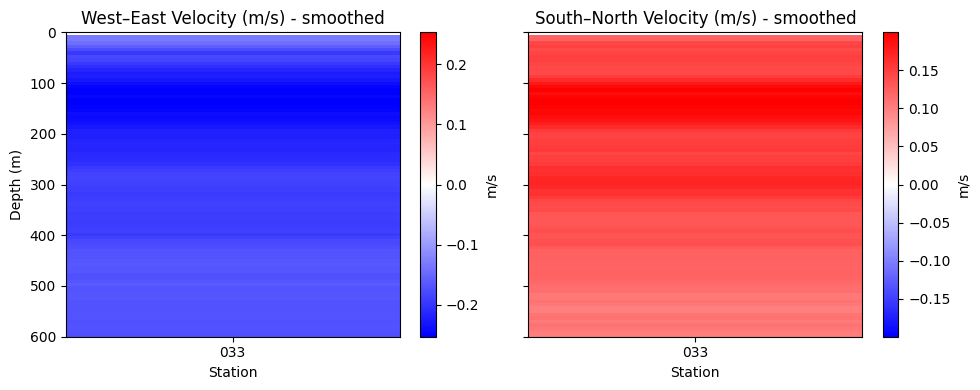

In [25]:
# files = sorted(glob.glob(os.path.join(file_dir, "ladcp_*.nc")))
#
# # Extract station numbers from filenames
# stations = [os.path.basename(f).split("_")[1].split(".")[0] for f in files]

# stations = ['002', '003', '004', '005', '006', '007']

# file_dir = "/Users/iw2g24/PycharmProjects/COOKIES/ladcp_nc"
# files = [
#     os.path.join(file_dir, f"ladcp_{stn}.nc")
#     for stn in stations
# ]

us = []
vs = []
depths = []

for f in ladcp_files:
    ds = xr.open_dataset(f)

    us.append(ds.dr_u.values)
    vs.append(ds.dr_v.values)
    depths.append(ds.dr_z.values)


u_grid = []
v_grid = []

for i in range(len(files)):
    z = depths[i]
    u = us[i]
    v = vs[i]

    # Ensure increasing depth
    order = np.argsort(z)
    z = z[order]
    u = u[order]
    v = v[order]

    u_grid.append(np.interp(z_grid, z, u, left=np.nan, right=np.nan))
    v_grid.append(np.interp(z_grid, z, v, left=np.nan, right=np.nan))

u_grid = np.vstack(u_grid)
v_grid = np.vstack(v_grid)


# -----------------------------
# 1. Build smoothed transect grids
# -----------------------------

sigma = 1.0

u_grid_smooth  = gaussian_filter1d(u_grid,  sigma=sigma, axis=0)
v_grid_smooth = gaussian_filter1d(v_grid, sigma=sigma, axis=0)


x = np.arange(len(files))
x_edges = np.arange(len(files) + 1)

z_edges = np.zeros(len(z_grid) + 1)
z_edges[1:-1] = (z_grid[:-1] + z_grid[1:]) / 2
z_edges[0] = z_grid[0] - (z_grid[1] - z_grid[0]) / 2
z_edges[-1] = z_grid[-1] + (z_grid[-1] - z_grid[-2]) / 2

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

variables = [
    (u_grid_smooth, "West–East Velocity (m/s) - smoothed", "bwr"),
    (v_grid_smooth, "South–North Velocity (m/s) - smoothed", "bwr"),
]

for ax, (var2d, title, cmap) in zip(axs, variables):
    abs_max = np.nanmax(np.abs(var2d))

    pcm = ax.pcolormesh(
        x_edges,
        z_edges,
        var2d.T,
        cmap=cmap,
        shading="auto",
        vmin=-abs_max,
        vmax=abs_max,
    )


    ax.set_title(title)
    ax.set_xlabel("Station")
    ax.set_xticks(x + 0.5)
    ax.set_xticklabels(stations)

    cbar = plt.colorbar(pcm, ax=ax)
    cbar.set_label("m/s")

axs[0].set_ylim(y_min, y_max)
axs[0].set_ylabel("Depth (m)")
ax.invert_yaxis()
plt.tight_layout()
plt.show()





Max depth-averaged speed: 0.2244211701527102


/var/folders/_b/mwrrgwfd7k53y4lg7_zfzvjm0000gp/T/ipykernel_70786/2343799557.py:90: RuntimeWarning: Mean of empty slice
  U_bar = np.nanmean(u_profiles[:, mask], axis=1)
/var/folders/_b/mwrrgwfd7k53y4lg7_zfzvjm0000gp/T/ipykernel_70786/2343799557.py:91: RuntimeWarning: Mean of empty slice
  V_bar = np.nanmean(v_profiles[:, mask], axis=1)


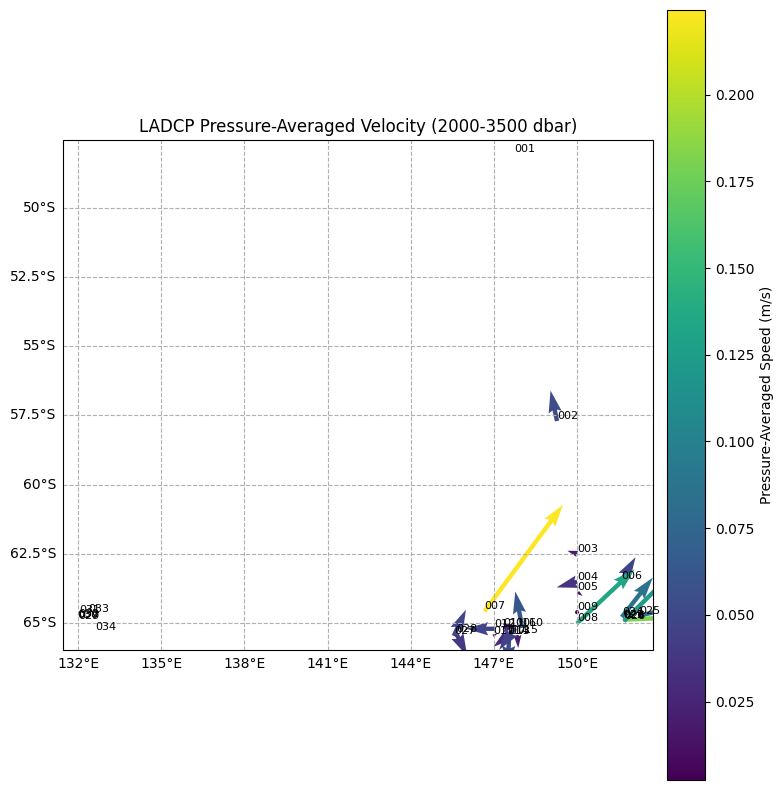

In [43]:
"""
Pressure-averaged LADCP velocity map
Computes pressure-averaged U and V (0–350 dbar)
and plots spatial quiver map.
"""

import numpy as np
import xarray as xr
import glob
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# -------------------------------------------------
# USER SETTINGS
# -------------------------------------------------
ladcp_dir = "/Users/iw2g24/PycharmProjects/COOKIES/Data/ladcp_nc/"
p_min = 2000
p_max = 3500
p_grid = np.arange(p_min, p_max + 5, 5)   # 5 dbar grid
# -------------------------------------------------

# Get files sorted by station number
ladcp_files = sorted(
    glob.glob(os.path.join(ladcp_dir, "*.nc")),
    key=lambda f: int(os.path.splitext(os.path.basename(f))[0].split('_')[-1])
)

stations = []
mean_lon = []
mean_lat = []
u_profiles = []
v_profiles = []

# -------------------------------------------------
# LOAD DATA
# -------------------------------------------------
for f in ladcp_files:
    ds = xr.open_dataset(f)

    # Station number
    stn = os.path.basename(f).split("_")[-1].split(".")[0]
    stations.append(stn)

    # --- Position ---
    # if "dr_lon" in ds.attrs:
    #     lon = ds.attrs["dr_lon"]
    #     lat = ds.attrs["dr_lat"]
    # else:
    #     lon = float(ds["dr_shiplon"].mean())
    #     lat = float(ds["dr_shiplat"].mean())

    lon = float(ds["dr_shiplon"].mean())
    lat = float(ds["dr_shiplat"].mean())
    mean_lon.append(lon)
    mean_lat.append(lat)

    # --- Velocity and depth ---
    u = ds["dr_u"].values
    v = ds["dr_v"].values
    z = ds["dr_z"].values
    p = ds["dr_p"].values

    # Remove NaNs before interpolation
    valid = np.isfinite(z) & np.isfinite(u) & np.isfinite(v) & np.isfinite(p)
    z = z[valid]
    u = u[valid]
    v = v[valid]
    p = p[valid]

    # Interpolate onto common pressure grid
    u_interp = np.interp(p_grid, p, u, left=np.nan, right=np.nan)
    v_interp = np.interp(p_grid, p, v, left=np.nan, right=np.nan)

    u_profiles.append(u_interp)
    v_profiles.append(v_interp)

# Convert to arrays
u_profiles = np.array(u_profiles)
v_profiles = np.array(v_profiles)
mean_lon = np.array(mean_lon)
mean_lat = np.array(mean_lat)

# -------------------------------------------------
# DEPTH AVERAGE
# -------------------------------------------------
mask = (p_grid >= p_min) & (p_grid <= p_max)

U_bar = np.nanmean(u_profiles[:, mask], axis=1)
V_bar = np.nanmean(v_profiles[:, mask], axis=1)

speed = np.sqrt(U_bar**2 + V_bar**2)

print("Max depth-averaged speed:", np.nanmax(speed))

# -------------------------------------------------
# PLOT MAP
# -------------------------------------------------
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=proj)

# Set map extent manually (expand a bit)
buffer = 0.5
ax.set_extent([
    mean_lon.min() - buffer,
    mean_lon.max() + buffer,
    mean_lat.min() - buffer,
    mean_lat.max() + buffer
], crs=ccrs.PlateCarree())

# Just gridlines (no coastline download)
gl = ax.gridlines(draw_labels=True, linestyle="--")
gl.top_labels = False
gl.right_labels = False

# Quiver
q = ax.quiver(
    mean_lon,
    mean_lat,
    U_bar,
    V_bar,
    speed,
    transform=ccrs.PlateCarree(),
    cmap="viridis",
    scale=1
)

cbar = plt.colorbar(q, ax=ax, pad=0.02)
cbar.set_label("Pressure-Averaged Speed (m/s)")

for stn, lon, lat in zip(stations, mean_lon, mean_lat):
    ax.text(lon, lat, stn, transform=ccrs.PlateCarree(),
            fontsize=8, ha="left", va="bottom")

ax.set_title(f"LADCP Pressure-Averaged Velocity ({p_min}-{p_max} dbar)")

plt.tight_layout()
plt.show()

Stations plotted: ['029', '030', '031', '032', '033', '034']
Max depth-averaged speed: 0.21199450634623038


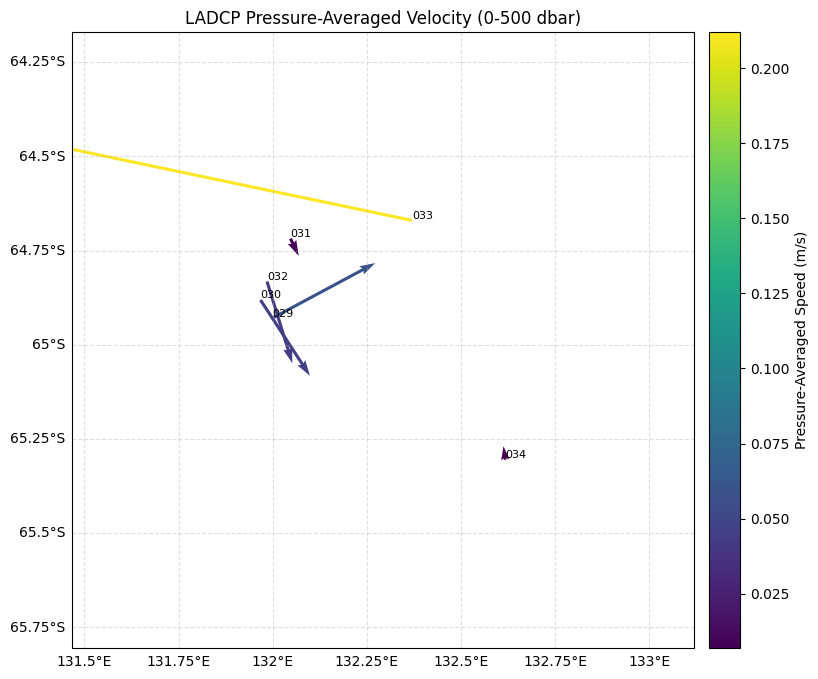

In [67]:
"""
Depth-averaged LADCP velocity map
Optionally restricts plot to selected stations.
"""

import numpy as np
import xarray as xr
import glob
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# -------------------------------------------------
# USER SETTINGS
# -------------------------------------------------
ladcp_dir = "/Users/iw2g24/PycharmProjects/COOKIES/Data/ladcp_nc/"

p_min = 0
p_max = 500
p_grid = np.arange(p_min, p_max + 5, 5)   # 5 dbar grid

# Optional: select subset of stations
selected_stations = ["029", "030", "031", "032",'033', "034"]
# selected_stations = None  # plot all stations

# Optional: manual map extent
extent = None  # 'manual' or None
min_lon, max_lon = 130, 135
min_lat, max_lat = -70, -64
# -------------------------------------------------

# -------------------------------------------------
# FIND FILES
# -------------------------------------------------
ladcp_files = sorted(
    glob.glob(os.path.join(ladcp_dir, "*.nc")),
    key=lambda f: int(os.path.splitext(os.path.basename(f))[0].split('_')[-1])
)

stations = []
mean_lon = []
mean_lat = []
u_profiles = []
v_profiles = []

# -------------------------------------------------
# LOAD & PROCESS DATA
# -------------------------------------------------
# for f in ladcp_files:
#     stn = os.path.basename(f).split("_")[-1].split(".")[0]
#
#     # Skip if not in selected list
#     if selected_stations is not None and stn not in selected_stations:
#         continue
#
#     ds = xr.open_dataset(f)

for stn in selected_stations:
    ds = xr.open_dataset(f'/Users/iw2g24/PycharmProjects/COOKIES/Data/ladcp_nc/ladcp_{stn}.nc')
    stations.append(stn)

    # --- Position ---
    # if "dr_lon" in ds.attrs:
    #     lon = ds.attrs["dr_lon"]
    #     lat = ds.attrs["dr_lat"]
    # else:
    #     lon = float(ds["dr_shiplon"].mean())
    #     lat = float(ds["dr_shiplat"].mean())


    lon = float(ds["dr_shiplon"].mean())
    lat = float(ds["dr_shiplat"].mean())

    mean_lon.append(lon)
    mean_lat.append(lat)

    # --- Velocity ---
    u = ds["dr_u"].values
    v = ds["dr_v"].values
    z = ds["dr_z"].values
    p = ds["dr_p"].values

    valid = np.isfinite(z) & np.isfinite(u) & np.isfinite(v) & np.isfinite(p)
    z = z[valid]
    u = u[valid]
    v = v[valid]
    p = p[valid]

    # Interpolate onto common pressure grid
    u_interp = np.interp(p_grid, p, u, left=np.nan, right=np.nan)
    v_interp = np.interp(p_grid, p, v, left=np.nan, right=np.nan)

    u_profiles.append(u_interp)
    v_profiles.append(v_interp)

# Convert to arrays
u_profiles = np.array(u_profiles)
v_profiles = np.array(v_profiles)
mean_lon = np.array(mean_lon)
mean_lat = np.array(mean_lat)

# -------------------------------------------------
# DEPTH AVERAGE
# -------------------------------------------------
mask = (p_grid >= p_min) & (p_grid <= p_max)
U_bar = np.nanmean(u_profiles[:, mask], axis=1)
V_bar = np.nanmean(v_profiles[:, mask], axis=1)
speed = np.sqrt(U_bar**2 + V_bar**2)

print(f"Stations plotted: {stations}")
print("Max depth-averaged speed:", np.nanmax(speed))

# -------------------------------------------------
# SIMPLE PLOT MAP
# -------------------------------------------------
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': proj})

# Set map extent
if extent == 'manual':
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
else:
    buffer = 0.5
    ax.set_extent([
        mean_lon.min() - buffer,
        mean_lon.max() + buffer,
        mean_lat.min() - buffer,
        mean_lat.max() + buffer
    ], crs=ccrs.PlateCarree())

# Gridlines
gl = ax.gridlines(draw_labels=True, linestyle="--", alpha=0.4)
gl.top_labels = False
gl.right_labels = False

# Adjust quiver scale automatically based on mean speed
mean_speed = np.nanmean(speed)
quiver_scale = mean_speed * 5  # tweak factor for arrow visibility

# Quiver plot
q = ax.quiver(
    mean_lon,
    mean_lat,
    U_bar,
    V_bar,
    speed,
    transform=ccrs.PlateCarree(),
    cmap="viridis",
    scale=quiver_scale,
    width=0.005
)

# Colorbar
cbar = fig.colorbar(q, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label("Pressure-Averaged Speed (m/s)")

# Station labels
for stn, lon, lat in zip(stations, mean_lon, mean_lat):
    ax.text(lon, lat, stn, transform=ccrs.PlateCarree(),
            fontsize=8, ha="left", va="bottom")

# Title
ax.set_title(f"LADCP Pressure-Averaged Velocity ({p_min}-{p_max} dbar)")

plt.show()


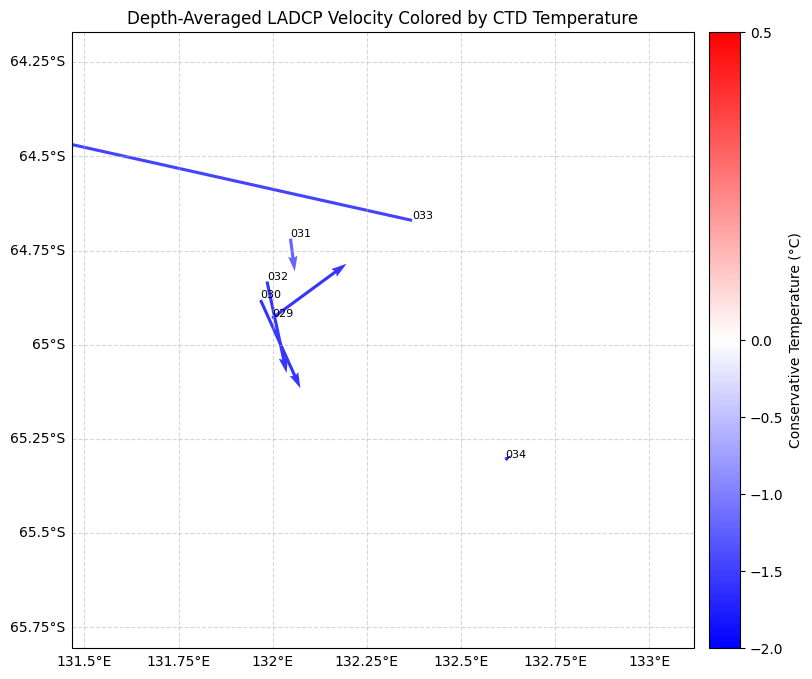

In [97]:
"""
Spatial quiver plot of LADCP velocity
Color-coded by CTD temperature
"""

import numpy as np
import xarray as xr
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs

# -------------------------------------------------
# USER SETTINGS
# -------------------------------------------------
data_dir = '/Users/iw2g24/PycharmProjects/COOKIES/Data/'
ladcp_dir = data_dir + 'ladcp_nc/'
ctd_dir = data_dir + 'ctd_data/'

selected_stations = ['029', '030', '031','032', '033', '034']  # subset of stations
p_min = 0
p_max = 350
p_grid = np.linspace(p_min, p_max, 100)  # common pressure grid for averaging/subsampling

temp_min = -2
temp_max = 0.5

# Quiver arrow subsampling
step = 5  # take every Nth depth point

# -------------------------------------------------
# LOAD CTD DATASETS
# -------------------------------------------------
files = glob.glob(os.path.join(ctd_dir, 'in2026_v01_*', 'in2026_v01_*.nc'))
files = sorted(files, key=lambda f: int(os.path.basename(f).split('_')[-1].split('.')[0]))

datasets = {}
for file_name in files:
    stn = os.path.basename(file_name).split('_')[-1].split('.')[0]
    datasets[stn] = xr.open_dataset(file_name, decode_timedelta=False)

# -------------------------------------------------
# PREPARE ARRAYS
# -------------------------------------------------
mean_lon, mean_lat = [], []
u_profiles, v_profiles, temp_profiles = [], [], []

for stn in selected_stations:
    # ---- LADCP ----
    ds_ladcp = xr.open_dataset(os.path.join(ladcp_dir, f'ladcp_{stn}.nc'))
    u = ds_ladcp['dr_u'].values
    v = ds_ladcp['dr_v'].values
    z = ds_ladcp['dr_z'].values
    p = ds_ladcp['dr_p'].values

    valid = np.isfinite(z) & np.isfinite(u) & np.isfinite(v) & np.isfinite(p)
    u = u[valid]
    v = v[valid]
    p = p[valid]

    # interpolate onto common pressure grid
    u_interp = np.interp(p_grid, p, u, left=np.nan, right=np.nan)
    v_interp = np.interp(p_grid, p, v, left=np.nan, right=np.nan)

    u_profiles.append(u_interp)
    v_profiles.append(v_interp)

    # station position
    lon = float(ds_ladcp['dr_shiplon'].mean())
    lat = float(ds_ladcp['dr_shiplat'].mean())
    mean_lon.append(lon)
    mean_lat.append(lat)

    # ---- CTD temperature ----
    ds_ctd = datasets[stn]
    p_ctd = ds_ctd.prDM.values
    t = ds_ctd.CT.values

    mask = p_ctd > 8.5
    p_ctd = p_ctd[mask]
    t = t[mask]

    order = np.argsort(p_ctd)
    p_ctd = p_ctd[order]
    t = t[order]

    temp_interp = np.interp(p_grid, p_ctd, t, left=np.nan, right=np.nan)
    temp_profiles.append(temp_interp)

# convert to arrays
u_profiles = np.array(u_profiles)
v_profiles = np.array(v_profiles)
temp_profiles = np.array(temp_profiles)
mean_lon = np.array(mean_lon)
mean_lat = np.array(mean_lat)

# -------------------------------------------------
# AVERAGE ACROSS DEPTH (optional)
# -------------------------------------------------
# If you want depth-averaged vectors:
U_bar = np.nanmean(u_profiles, axis=1)
V_bar = np.nanmean(v_profiles, axis=1)
T_bar = np.nanmean(temp_profiles, axis=1)  # temperature to color arrows

# -------------------------------------------------
# PLOT SPATIAL QUIVER
# -------------------------------------------------
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': proj})

# Map extent
buffer = 0.5
ax.set_extent([
    mean_lon.min() - buffer,
    mean_lon.max() + buffer,
    mean_lat.min() - buffer,
    mean_lat.max() + buffer
], crs=ccrs.PlateCarree())

# Gridlines
gl = ax.gridlines(draw_labels=True, linestyle="--", alpha=0.5)
gl.top_labels = False
gl.right_labels = False

norm = mcolors.TwoSlopeNorm(
    vmin=temp_min,
    vcenter=0.0,
    vmax=temp_max
)


# Quiver scale
speed = np.sqrt(U_bar**2 + V_bar**2)
quiver_scale = np.nanmean(speed) * 5

# Plot quiver
q = ax.quiver(
    mean_lon, mean_lat,
    U_bar, V_bar,
    T_bar,
    transform=ccrs.PlateCarree(),
    cmap='bwr',
    norm=norm,
    scale=quiver_scale,
    width=0.005
)

# Colorbar
cbar = fig.colorbar(q, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label("Conservative Temperature (°C)")

# Station labels
for stn, lon, lat in zip(selected_stations, mean_lon, mean_lat):
    ax.text(lon, lat, stn, transform=ccrs.PlateCarree(),
            fontsize=8, ha='left', va='bottom')

ax.set_title("Depth-Averaged LADCP Velocity Colored by CTD Temperature")
plt.show()


/var/folders/_b/mwrrgwfd7k53y4lg7_zfzvjm0000gp/T/ipykernel_70786/731617292.py:96: RuntimeWarning: Mean of empty slice
  T_bar = np.nanmean(temp_profiles[:, mask], axis=1)


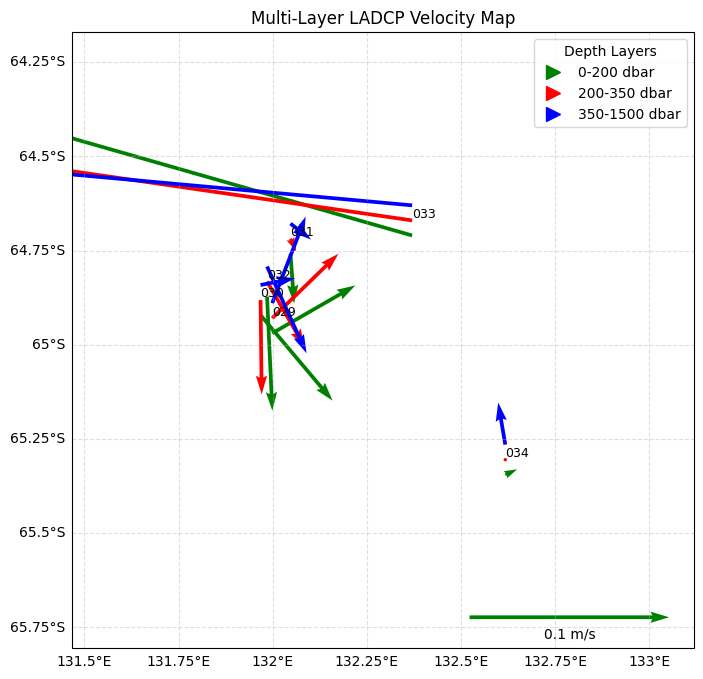

In [91]:
import numpy as np
import xarray as xr
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import matplotlib.lines as mlines

# -------------------------------------------------
# USER SETTINGS
# -------------------------------------------------

data_dir = '/Users/iw2g24/PycharmProjects/COOKIES/Data/'
ladcp_dir = data_dir + 'ladcp_nc/'
ctd_dir = data_dir + 'ctd_data/'

selected_stations = ['029', '030', '031','032', '033', '034']  # subset of stations
p_min = 0
p_max = 350
p_grid = np.linspace(p_min, p_max, 200)

# Define pressure layers
pressure_layers = [
    (0, 200),
    (200, 350),
    (350, 1500)
]

# Small latitude offsets so layers don't overlap
layer_offsets = np.linspace(-0.04, 0.04, len(pressure_layers))

# Map extent option
extent = None  # 'manual' or None
min_lon, max_lon = 130, 135
min_lat, max_lat = -70, -64

mean_lon, mean_lat = [], []
u_profiles, v_profiles, temp_profiles = [], [], []

for stn in selected_stations:

    # ----- LADCP -----
    ds_ladcp = xr.open_dataset(os.path.join(ladcp_dir, f'ladcp_{stn}.nc'))

    u = ds_ladcp['dr_u'].values
    v = ds_ladcp['dr_v'].values
    p = ds_ladcp['dr_p'].values

    valid = np.isfinite(u) & np.isfinite(v) & np.isfinite(p)
    u, v, p = u[valid], v[valid], p[valid]

    u_interp = np.interp(p_grid, p, u, left=np.nan, right=np.nan)
    v_interp = np.interp(p_grid, p, v, left=np.nan, right=np.nan)

    u_profiles.append(u_interp)
    v_profiles.append(v_interp)

    mean_lon.append(float(ds_ladcp['dr_shiplon'].mean()))
    mean_lat.append(float(ds_ladcp['dr_shiplat'].mean()))

    # ----- CTD Temperature -----
    ds_ctd = datasets[stn]
    p_ctd = ds_ctd.prDM.values
    t = ds_ctd.CT.values

    mask = p_ctd > 8.5
    p_ctd, t = p_ctd[mask], t[mask]

    order = np.argsort(p_ctd)
    p_ctd, t = p_ctd[order], t[order]

    temp_interp = np.interp(p_grid, p_ctd, t, left=np.nan, right=np.nan)
    temp_profiles.append(temp_interp)

# Convert to arrays
u_profiles = np.array(u_profiles)
v_profiles = np.array(v_profiles)
temp_profiles = np.array(temp_profiles)
mean_lon = np.array(mean_lon)
mean_lat = np.array(mean_lat)

#multi layer averages
U_layers = []
V_layers = []
T_layers = []
lon_layers = []
lat_layers = []

for offset, (p1, p2) in zip(layer_offsets, pressure_layers):

    mask = (p_grid >= p1) & (p_grid <= p2)

    U_bar = np.nanmean(u_profiles[:, mask], axis=1)
    V_bar = np.nanmean(v_profiles[:, mask], axis=1)
    T_bar = np.nanmean(temp_profiles[:, mask], axis=1)

    U_layers.append(U_bar)
    V_layers.append(V_bar)
    T_layers.append(T_bar)

    lon_layers.append(mean_lon)
    lat_layers.append(mean_lat + offset)

proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': proj})

# Map extent
if extent == 'manual':
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=proj)
else:
    buffer = 0.5
    ax.set_extent([
        mean_lon.min() - buffer,
        mean_lon.max() + buffer,
        mean_lat.min() - buffer,
        mean_lat.max() + buffer
    ], crs=proj)

gl = ax.gridlines(draw_labels=True, linestyle="--", alpha=0.4)
gl.top_labels = False
gl.right_labels = False

# Colors per layer
layer_colors = ['green', 'red', 'blue']

# Arrow scaling
all_speeds = np.sqrt(np.concatenate(U_layers)**2 +
                     np.concatenate(V_layers)**2)
quiver_scale = np.nanmean(all_speeds) * 5

# Plot layers
quiver_handles = []

for i, (p1, p2) in enumerate(pressure_layers):

    q = ax.quiver(
        lon_layers[i],
        lat_layers[i],
        U_layers[i],
        V_layers[i],
        color=layer_colors[i],
        transform=proj,
        scale=quiver_scale,
        width=0.006
    )

    quiver_handles.append(q)
# -------------------------------------------------
# VECTOR SCALE BAR
# -------------------------------------------------
reference_speed = 0.1  # m/s

ax.quiverkey(
    quiver_handles[0],      # use first quiver object
    X=0.80,                 # horizontal position (axes coords)
    Y=0.05,                 # vertical position
    U=reference_speed,
    label=f'{reference_speed} m/s',
    labelpos='S',
    labelcolor = 'black'
)


# Station labels
for stn, lon, lat in zip(selected_stations, mean_lon, mean_lat):
    ax.text(lon, lat, stn, transform=proj,
            fontsize=9, ha='left', va='bottom')

# Legend
legend_handles = [
    mlines.Line2D([], [], color=layer_colors[i], marker='>',
                  linestyle='None', markersize=10,
                  label=f'{p1}-{p2} dbar')
    for i, (p1, p2) in enumerate(pressure_layers)
]

ax.legend(handles=legend_handles, title="Depth Layers", loc='upper right')

ax.set_title("Multi-Layer LADCP Velocity Map")

plt.show()
